In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
config = '/home/ekoenig/analysis/studies/configs/nanohh4b/nanohh4b.yaml'

import scripts.nanohh4b.nanohh4b as skim

analysis = skim.Analysis.load(
    config,
    model = '/home/ekoenig/analysis/weaver-multiH/models/feynnet_lightning/nanoHH4b/sixjet/particle-classifier-scan/20231029/lightning_logs/version_13861006',
    # no_data=True,
    ttbar_2_big=True,
)

In [188]:
analysis.run(['build_bkg_model', 'train_bdt_classifier'])

0:00:00 [  done  ] init()
        [  done  ] set_pt_threshold(signal, bkg, data)
        [  done  ] set_bdisc_threshold(signal, bkg, data)
        [  done  ] hh_mass_cut(signal, bkg, data)
        [  done  ] load_feynnet(signal, bkg, data)
        [disabled] plot_jet_multiplicity(signal, bkg, data)
        [disabled] plot_reco_eff(signal)
        [disabled] plot_feynnet(signal, bkg)
        [disabled] plot_higgs(signal, bkg)
        [disabled] plot_region_vars(signal, bkg)
        [disabled] print_4btag_yields(signal, bkg, data)
        [disabled] plot_4b_control(signal, bkg, data)
        [disabled] print_3btag_yields(signal, bkg, data)
        [disabled] plot_3b_control(signal, bkg, data)
        [  done  ] blind_data(data)
        [disabled] print_abcd_yields(signal, bkg, data)
        [disabled] plot_3btag_datamc(data, bkg)
        [  done  ] train_bdt(data)
        [  done  ] build_bkg_model(signal, bkg, data)
        [disabled] write_asr_4b(signal, bkg, bkg_model)
        [disabl

In [182]:
signal = analysis.signal
bkg = analysis.bkg
bkg_model = analysis.bkg_model

In [184]:
bkg_model.dHH_H1_feynprob

[<Array [0.992, 0.988, 0.997, ... 0.663, 0.423] type='51711 * float32'>]

100%|██████████| 4/4 [01:04<00:00, 16.17s/it]


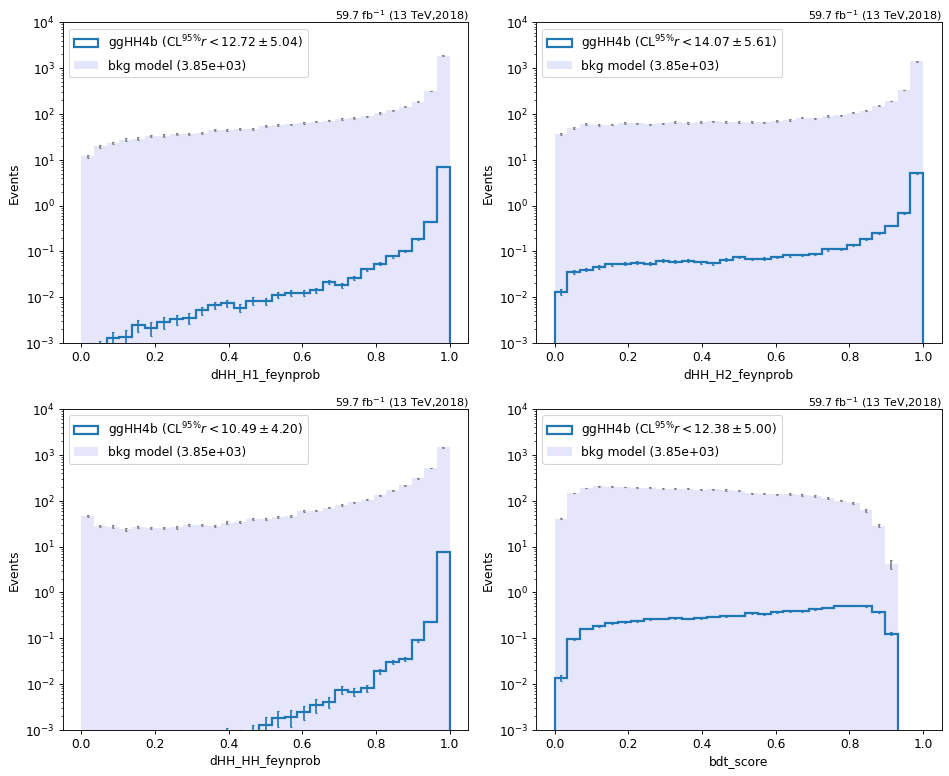

In [195]:
study.quick(
    signal + bkg_model,
    varlist=['dHH_H1_feynprob','dHH_H2_feynprob', 'dHH_HH_feynprob', 'bdt_score'],
    binlist=[(0,1,30)]*4, ylim=(1e-3, 1e4), legend=True,
    log=True,

    limits=True,
)

In [213]:
def shuffle_feynprob(tree):
    mask = np.random.randint(0, 2, len(tree), dtype=bool)
    tree.extend(
        dHH_Ha_feynprob = np.where(mask, tree.dHH_H1_feynprob, tree.dHH_H2_feynprob),
        dHH_Hb_feynprob = np.where(mask, tree.dHH_H2_feynprob, tree.dHH_H1_feynprob),
    )

(signal + bkg_model).apply(shuffle_feynprob)

[None, None]

100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


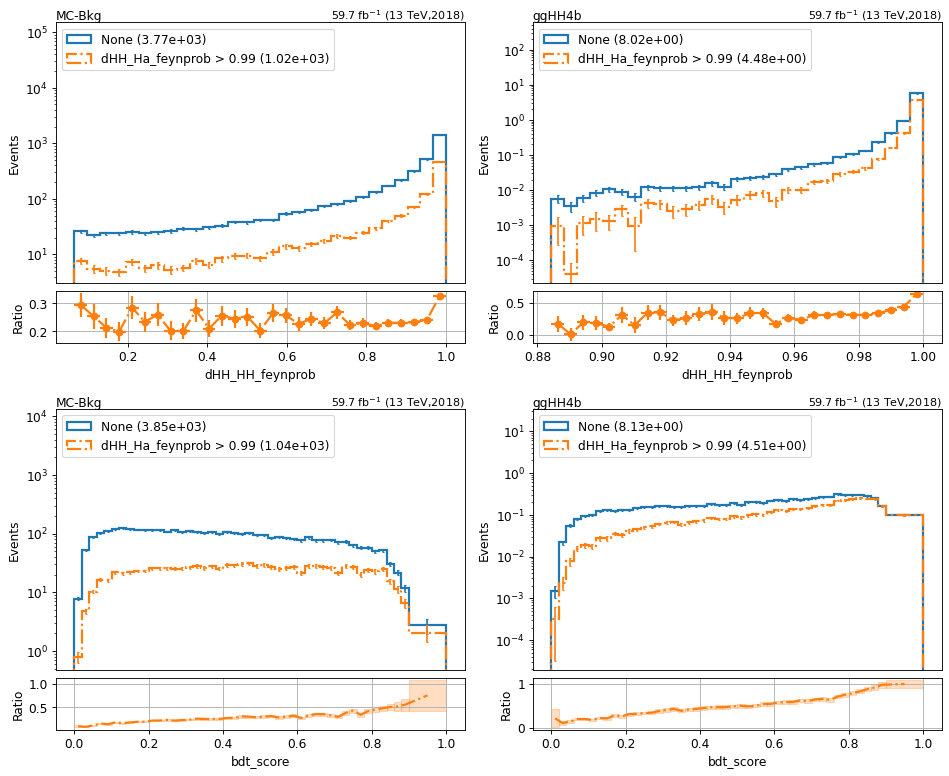

In [216]:
study.compare_masks(
    signal, bkg_model,
    h_color=None, 
    masks=[None, 'dHH_Ha_feynprob > 0.99'],
    varlist=['dHH_HH_feynprob','bdt_score'], legend=True,
    log=True,

    ratio=True, r_ylim=None, r_inv=True,
)

In [171]:
class quantile_transform:
    def __init__(self, x, w):
        x = flatten(x)
        w = flatten(w)

        mask = x > 0
        x = x[mask]
        w = w[mask]

        order = np.argsort(x)
        self.x = x[order]

        w = w[order]
        self.cdf = (np.cumsum(w) - 0.5*w)/np.sum(w)

    def __call__(self, x):
        return np.interp(x, self.x, self.cdf)



In [223]:
dHH_H1_feynprob = quantile_transform(bkg_model.dHH_H1_feynprob.cat, bkg_model.scale.cat)
dHH_H2_feynprob = quantile_transform(bkg_model.dHH_H2_feynprob.cat, bkg_model.scale.cat)
dHH_HH_feynprob = quantile_transform(bkg_model.dHH_HH_feynprob.cat, bkg_model.scale.cat)
bdt_score = quantile_transform(bkg_model.bdt_score.cat, bkg_model.scale.cat)

In [224]:
(signal + bkg_model).apply(lambda t : t.extend(
    dHH_H1_feynquantile = dHH_H1_feynprob(t.dHH_H1_feynprob),
    dHH_H2_feynquantile = dHH_H2_feynprob(t.dHH_H2_feynprob),
    dHH_HH_feynquantile = dHH_HH_feynprob(t.dHH_HH_feynprob),
    bdt_quantile = bdt_score(t.bdt_score),
))

[None, None]

100%|██████████| 4/4 [00:53<00:00, 13.48s/it]


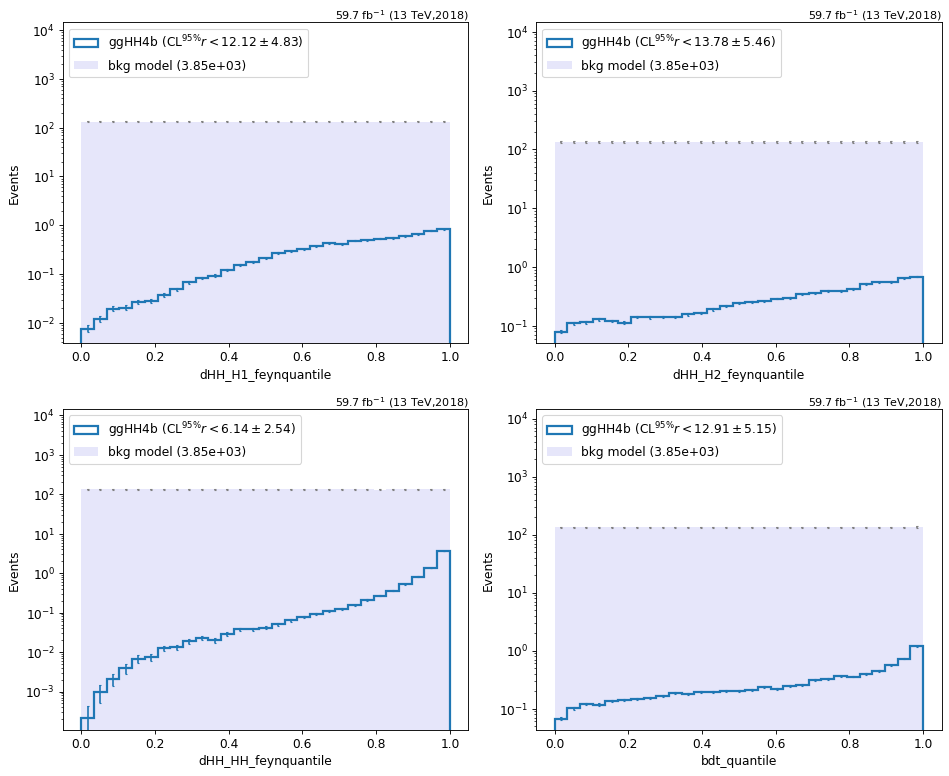

In [226]:
study.quick(
    signal + bkg_model,
    varlist=['dHH_H1_feynquantile', 'dHH_H2_feynquantile', 'dHH_HH_feynquantile','bdt_quantile'],
    legend=True,
    log=True, 
    limits=True,
)

In [178]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: key "dHH_H1_feynquantile" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/libawkward/util.cpp#L525)

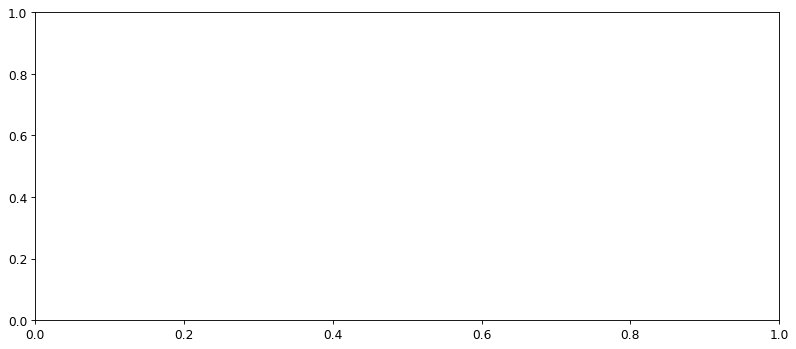

In [217]:
study.quick2d(
    signal + bkg_model,
    varlist=['dHH_H1_feynquantile', 'dHH_H2_feynquantile'],
    binlist=[(0,1,5)]*2,
    legend=True, efficiency=True,
    show_counts=True,
)

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


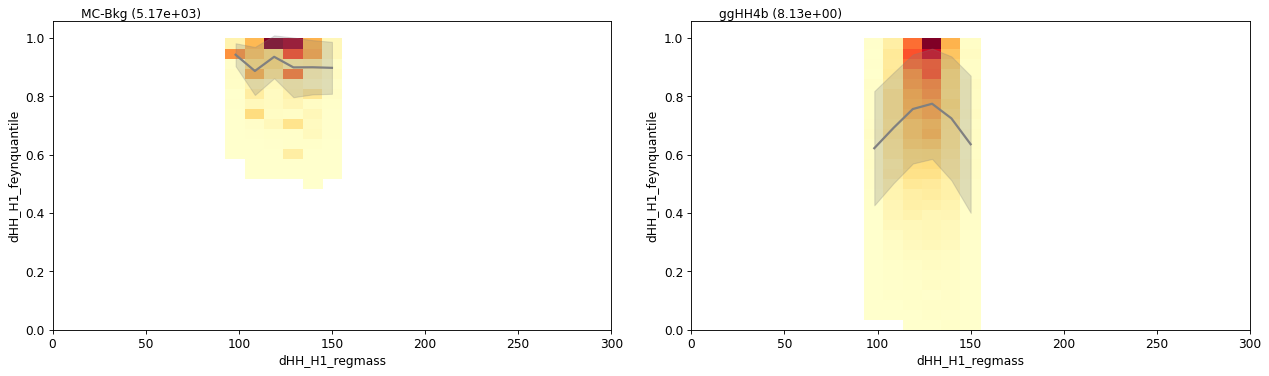

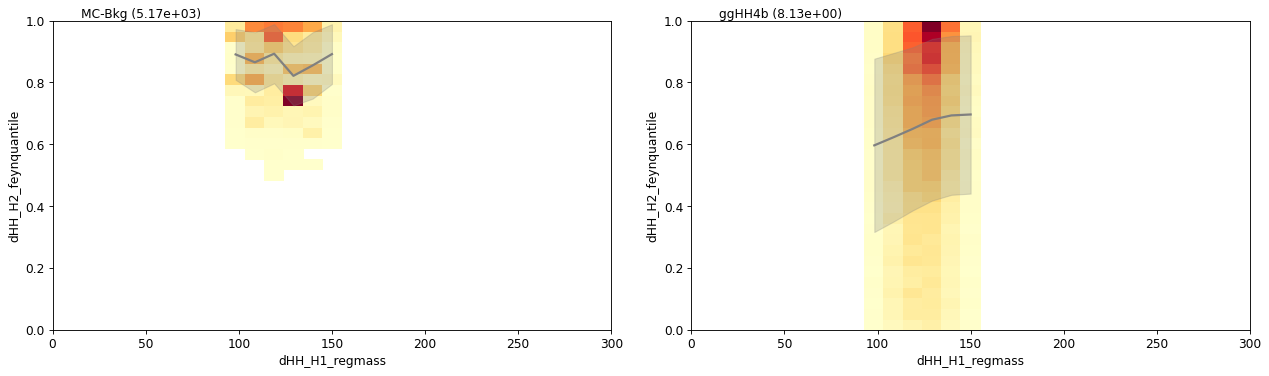

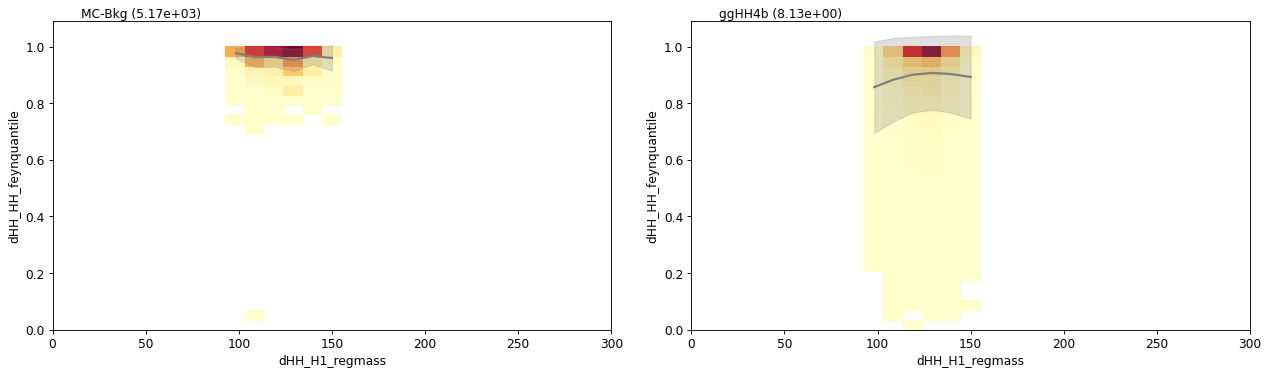

In [227]:
study.quick2d(
    signal + bkg,
    # masks=lambda t : t['dHH_H1_feynquantile'] > 0,
    varlist=['dHH_H1_regmass', 'dHH_H1_feynquantile'],
    binlist=[(0,300,30), (0,1,30)],
    legend=True, efficiency=True,
    exe=plot_histo2d_x_corr
)

study.quick2d(
    signal + bkg,
    masks=lambda t : t['dHH_H2_feynquantile'] > 0,
    varlist=['dHH_H1_regmass', 'dHH_H2_feynquantile'],
    binlist=[(0,300,30), (0,1,30)],
    legend=True, efficiency=True,
    exe=plot_histo2d_x_corr
)

study.quick2d(
    signal + bkg,
    masks=lambda t : t['dHH_HH_feynquantile'] > 0,
    varlist=['dHH_H1_regmass', 'dHH_HH_feynquantile'],
    binlist=[(0,300,30), (0,1,30)],
    legend=True, efficiency=True,
    exe=plot_histo2d_x_corr
)